In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

In [2]:
# generate a single circular sinusoidal grating with the specified orientation and SF
# theta - grating orientation (radians)
# diameter - stimulus size (degrees)
# SF - spatial frequency (cycles / frame)
# pix_deg - number of pixels per degree scale factor
# phi - sinusoid phase shift (radians)
def generate_static_grating(theta, diameter, SF, pix_deg, phi=0, masked=False, norm=False):
    fsize = pix_deg * diameter # pixels per size of img
    
    vals = np.linspace(-np.pi, np.pi, fsize)
    xv, yv = np.meshgrid(vals, vals)
    
    xy = xv*np.cos(theta) + yv*np.sin(theta)
    
    my,mx = np.ogrid[-fsize/2:fsize/2, -fsize/2:fsize/2] 
    
    mask = np.ones((fsize, fsize))
    
    if masked:
        mask[ np.where( np.sqrt((mx+1)**2 + (my+1)**2) > fsize/2) ] = 0
    
    grating = np.cos( SF * xy + phi ) * mask
    
    # normalize the grating from zero to one:
    if norm:
        grating = grating + np.abs(np.min(grating))
        grating = grating/np.max(grating)
    
    return grating

def generate_grating_bank(orientations, diameter, SF, pix_deg, phi=0):
    fsize = pix_deg*diameter
    bank = np.zeros((orientations.size,fsize,fsize))
    
    for i in range(orientations.size):
        bank[i,:,:] = generate_static_grating(orientations[i], diameter, SF, pix_deg, phi)
        
    return bank

# generate a circular sinusoidal grating with the specified orientation and SF
# drifting for a specified time and with specified frequency
# theta - grating orientation (radians)
# diameter - stimulus size (degrees)
# SF - spatial frequency (cycles / frame)
# TF - temporal frequency (cycles / second)
# time - length of time of stimulus (seconds)
# pix_deg - number of pixels per degree scale factor
def generate_drifting_grating(theta, diameter, SF, TF, time, pix_deg, n_frames):
    fsize = pix_deg*diameter
    frames = np.zeros((fsize,fsize,n_frames))
    
    phi = np.arange()
    
    for i in range(phi.size):
        frames[:,:,i] = generate_static_grating(theta, diameter, SF, pix_deg, phi[i])

    return frames

def generate_bar(theta, size, pix_deg):
    pass

# Generates a 2-D Gabor function with the specified parameters
# Used for generating simple cell receptive fields
def gabor(sig_x, sig_y, theta, k, phi, fsize):
    
#     sig_x = sig_x/fsize
#     sig_y = sig_y/fsize
    vals = np.linspace(-np.pi, np.pi, fsize)
    xgrid,ygrid = np.meshgrid(vals,vals)
    xy = xgrid*np.cos(theta) + ygrid*np.sin(theta)
    sine = np.sin(k*xy + phi)
    gaussian = np.exp(-(xgrid/(2*sig_x**2))**2-(ygrid/(2*sig_y**2))**2)
    
#     plt.figure()
#     plt.imshow(sine, cm.gray)
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(gaussian, cm.gray)
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(gaussian*sine - sine)
#     plt.colorbar()
    
    return gaussian*sine

# Returns the response of a LIF neuron with gabor RF to an oriented static grating
# this function is used for fitting tuning curves to data via scipy.optimize.curve_fit
def LIF_neuron( stim_ori, sig_x, sig_y, theta, k, phi, gain, J_bias, RC_factor):
    
    RF_size = 1 # diameter of RF, degrees
    pix_deg = 25 # scale factor
    
    tau_ref = 0.002
    tau_RC = 0.05 * RC_factor
    neuronRF = gabor(sig_x, sig_y, theta, phi, k, RF_size)
    
    bank = generate_grating_bank(stim_ori, RF_size, 4, pix_deg)
    
    J = gain*np.sum( bank.reshape( stim_ori.size, RF_size*pix_deg**2 ) * neuronRF.flatten(), 1 ) + J_bias
    
    # LIF nonlinearity
#     J[J<0] = 0
#     print 'J: ', J
#     a = 1/(tau_ref - tau_RC*np.log(1 - (1/J) ) )
    
#     print 'a: ', a

    # From Nengo LIFRate neuron:
    j = J-1
    output = np.zeros_like(j)
    output[:] = 0
    output[j>0] = 1. / ( tau_ref + tau_RC*np.log1p(1. / j[j>0]))
    
    return output

# Returns the response of a LIF neuron with gabor RF to an oriented static grating
# this function is used to find the response of a given RF to a specified set of stimuli
# assumes a square RF
def RF_response( stimuli, neuron_RF, LIF_params, show_current=False ):
    
    tau_ref = 0.002
    gain = LIF_params[0]
    J_bias = LIF_params[1]
    tau_RC = LIF_params[2] * 0.05
    
    fsize = neuron_RF.shape[0]
    
    bank = generate_grating_bank(stimuli, 1, 4, fsize)
    
    J = gain*np.sum( bank.reshape( stimuli.size, fsize**2 ) * neuron_RF.flatten(), 1 ) + J_bias
    
#     # LIF nonlinearity
#     J[J<0] = 0
#     a = 1/(tau_ref - tau_RC*np.log(1 - (1/J) ) )
#     a[np.isnan(a)] = 0
#     return a
    if show_current:
        plt.figure()
        plt.plot(stimuli, J)
        plt.title('Input current to neuron')
        plt.xlabel('Orientation (radians)')
        plt.ylabel('Current')
        
    # From Nengo LIFRate neuron:
    j = J-1
    output = np.zeros_like(j)
    output[:] = 0
    output[j>0] = 1. / ( tau_ref + tau_RC*np.log1p(1. / j[j>0]))
    
    return output

In [15]:
# A class for a V1 neuron, which can either be simple or complex

class v1_neuron:
    
    def __init__(self, RF_size, orient_pref, sf_pref, oc_dom, cell_type='simple' ):
        self.pix_deg = 25 
        # generate ipsilateral and contralateral receptive fields:
        self.RF = self.generate_RF(RF_size, orient_pref, sf_pref, oc_dom)
        self.LIF_params = self.get_LIF_params()
        
    def generate_RF(self, RF_size, orient_pref, sf_pref, oc_dom):
        sig_x
        ipsi_RF = gabor()
        contra_RF = gabor()
        return np.array([ipsi_RF, contra_RF])
    
    def get_LIF_params():
        gain = 1
        J_bias = 0
        RC_factor = 1
        return [gain, J_bias, RC_factor]

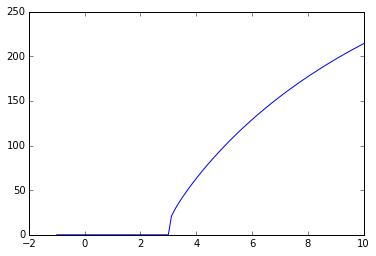

In [3]:
x = np.linspace(-1,10,100)
tau_rc=0.02
tau_ref=0.002
gain = 1
bias = -2

J = gain*x + bias
j = J-1
output = np.zeros_like(j)
output[:] = 0
output[j>0] = 1. / ( tau_ref + tau_rc*np.log1p(1. / j[j>0]))
plt.figure()
plt.plot(x, output)
# plt.axis((-1,10,-10,250))

Neuron RF properties:  [  -42.50788646     6.46177362     5.66744189   172.9893382    -33.23446901
 -3158.16880374    95.06017189   190.31653017]
Covariance:  [[  1.95105536e+18  -2.26336904e+17  -3.26741669e+10   2.14765858e+13
    1.78111275e+13  -8.55912914e+19   1.52003352e+18   3.05935196e+18]
 [ -1.99282506e+17   6.99952463e+16   1.05739849e+10  -6.69700440e+12
   -8.04552977e+12   6.59495139e+18  -4.58927427e+17  -9.23677347e+17]
 [ -5.34235563e+10   1.98490208e+10  -2.44015660e+03   1.48250256e+06
    1.13444912e+06   3.06582891e+12  -1.74351568e+11  -3.50915165e+11]
 [  3.44752964e+13  -1.25261431e+13   1.49682318e+06  -9.07659343e+08
   -6.96595454e+08  -2.01534051e+15   1.10265728e+14   2.21930416e+14]
 [  2.97477840e+13  -1.37030156e+13   1.38121519e+06  -8.42947097e+08
   -5.11643890e+08  -1.37663470e+15   1.18726579e+14   2.38959463e+14]
 [ -8.89961028e+19   9.41688487e+18   2.06915859e+12  -1.39331417e+15
   -8.43790044e+14   8.06675682e+21  -1.00828106e+20  -2.02935435e

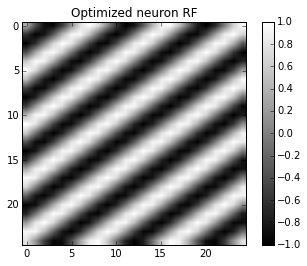

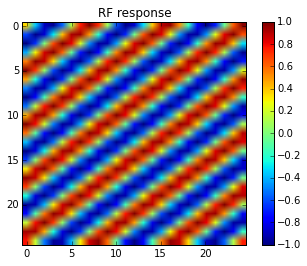

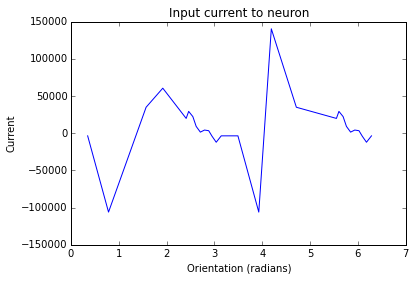

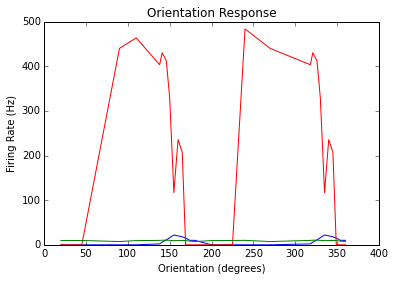

In [14]:
rate = np.array( [10, 10, 15, 18, 20, 22, 16, 11, 6,  2, 0, 0, 0, 0, 10, 10, 15, 18, 20, 22, 16, 11, 6, 2, 0, 0, 0, 0] )
orientation_deg = np.array( [360, 354, 349, 345, 340, 335, 330, 326, 321, 318, 270, 240, 225, 200, 180, 174, 169, 165, 160, 155, 150, 146, 141, 138, 110, 90, 45, 20] )

# convert orientations to radians:
orientation = orientation_deg*np.pi/180.

# convert rates to float64 to work with scipy.curve_fit
rate = rate.astype(float)

sigx = 1.65
sigy = 0.76
theta = 5.82
k = 4.4
phi = 0.
gain = 48.
J_bias = 0.86
RC_factor = 4.19

init = np.array([sigx, sigy, theta, k, phi, gain, J_bias, RC_factor])

popt, pconv = curve_fit( LIF_neuron, orientation, rate, p0=init )

print "Neuron RF properties: ", popt

print "Covariance: ", pconv

fsize = 25
neuronRF = gabor( popt[0], popt[1], popt[2], popt[3], popt[4], fsize )
# neuronRF = gabor( 1.6503, 0.7605, 5.8177, 4.4195, 0.0012, fsize )

LIF_params = [popt[5], popt[6], popt[7]]

plt.figure()
plt.imshow( neuronRF, cm.gray )
plt.colorbar()
plt.title('Optimized neuron RF')

rf_output = RF_response(orientation, neuronRF, LIF_params, show_current=True)
print rf_output

p_out = LIF_neuron(orientation, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7] )

print p_out

plt.figure()
plt.plot(orientation_deg, rate, 'b',  orientation_deg, rf_output, 'r', orientation_deg, p_out, 'g' )
plt.xlabel('Orientation (degrees)')
plt.ylabel('Firing Rate (Hz)')
# plt.legend('Data (De Angelis et al., 1982)', 'Model Fit')
plt.title('Orientation Response')


LIF params:  [48.0482, 0.8576, 4.1878]
Orientations:  [ 6.28318531  6.17846555  6.09119909  6.02138592  5.93411946  5.84685299
  5.75958653  5.68977336  5.6025069   5.55014702  4.71238898  4.1887902
  3.92699082  3.4906585   3.14159265  3.0368729   2.94960644  2.87979327
  2.7925268   2.70526034  2.61799388  2.54818071  2.46091425  2.40855437
  1.91986218  1.57079633  0.78539816  0.34906585]


<matplotlib.colorbar.Colorbar instance at 0x1084654d0>

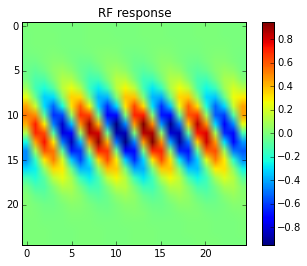

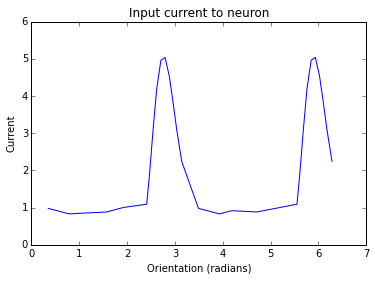

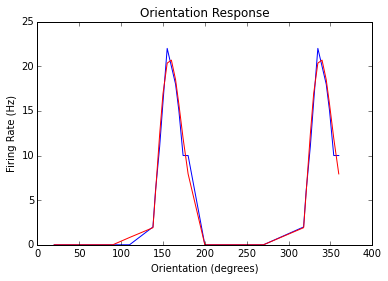

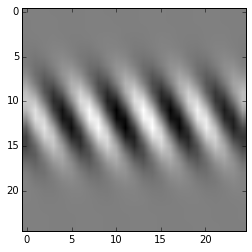

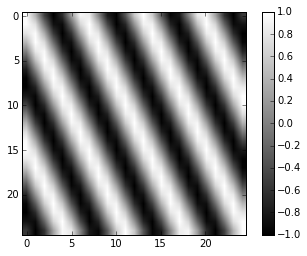

In [8]:
neuronRF = gabor( 1.6503, 0.7605, 5.8177, 4.4195, 0.0012, fsize )

LIF_params = [48.0482, 0.8576, 4.1878]

rf_output = RF_response(orientation, neuronRF, LIF_params, show_current=True)

plt.figure()
plt.plot(orientation_deg, rate, 'b',  orientation_deg, rf_output, 'r' )
plt.xlabel('Orientation (degrees)')
plt.ylabel('Firing Rate (Hz)')
# plt.legend('Data (De Angelis et al., 1982)', 'Model Fit')
plt.title('Orientation Response')

plt.figure()
plt.imshow(neuronRF, cm.gray)

plt.figure()
plt.imshow(generate_static_grating(335*np.pi/180, 1, 4, 25), cm.gray )
plt.colorbar()